## Learning Word Vectors with TensorFlow: Hyperparameter Tuning
### Random Weight Initialization
*Patrick Coady (pcoady@alum.mit.edu)*

This notebook explores (again, with RMSProp optimizer):
1. Weight matrix initialization (amplitude of noise)
2. Truncated vs. standard normal initialization for hidden to softmax

Embedding Layer: A uniform zero-mean distribution was used. With small initialization weights ([-0.01, 0.01]) the learning gets stuck on a plateau (eventually breaking free). After falling off the plateau, a few of the "small initialization" scenarios look like they may reach a better solution (which is not unexpected). With large weight initialization ([-1, 1]), we see the classic situation of getting stuck in a local minima. Overall, [-0.1, 0.1] seems a good compromise.

Hidden to Softmax: Here a weight initialization of $\sigma = 0.1/\sqrt{N}$ worked well. Training was halted after only 50 epochs. Performance was not hurt until initialization was increased to $\sigma = 10/\sqrt{N}$.

(The conditions are listed above each set of plots. 10% of the data was set aside for validation.)

In [1]:
from wordvector import WordVector
from windowmodel import WindowModel
import docload
from plot_util import plot_results

import numpy as np
import sklearn.utils

In [2]:
files = ['../data/adventures_of_sherlock_holmes.txt',
        '../data/hound_of_the_baskervilles.txt',
        '../data/sign_of_the_four.txt']
word_array, dictionary, num_lines, num_words = docload.build_word_array(
    files, vocab_size=50000, gutenberg=True)
print('Document loaded and processed: {} lines, {} words.'
      .format(num_lines, num_words))

Document loaded and processed: 24080 lines, 244986 words.


In [3]:
x, y = WindowModel.build_training_set(word_array)

# shuffle and split 10% validation data
x_shuf, y_shuf = sklearn.utils.shuffle(x, y, random_state=0)
split = round(x_shuf.shape[0]*0.9)
x_val, y_val = (x_shuf[split:, :], y_shuf[split:, :])
x_train, y_train = (x[:split, :], y[:split, :])

## Embedding Weights Initialization
Embedding matrix initialized over zero-mean uniform distribution. Try uniform distribution widths of: {0.02, 0.2, 2}

***Result: Width of 2 needed to reliably avoid stalling on plateau***

In [4]:
results_list = []
count = 0
for embed_noise in [0.01, 0.1, 1]:
    for dummy in range(2):  # run each sim twice
        print('{}) embed noise = {}, run #{}'.format(count, embed_noise, dummy))
        count += 1
        graph_params = {'batch_size': 32,
                        'vocab_size': np.max(x)+1,
                        'embed_size': 128,
                        'hid_size': 128,
                        'neg_samples': 64,
                        'learn_rate': 0.003,
                        'embed_noise': embed_noise,
                        'optimizer': 'RMSProp'}
        model = WindowModel(graph_params)
        results = model.train(x_train, y_train, x_val, y_val, epochs=80, verbose=False)
        results_list.append((graph_params, results))

0) embed noise = 0.01, run #0
End Training: total batches = 551200. train loss = 1.29, val loss = 1.54
1) embed noise = 0.01, run #1
End Training: total batches = 551200. train loss = 1.24, val loss = 1.50
2) embed noise = 0.1, run #0
End Training: total batches = 551200. train loss = 1.26, val loss = 1.53
3) embed noise = 0.1, run #1
End Training: total batches = 551200. train loss = 1.26, val loss = 1.52
4) embed noise = 1, run #0
End Training: total batches = 551200. train loss = 1.50, val loss = 1.75
5) embed noise = 1, run #1
End Training: total batches = 551200. train loss = 1.52, val loss = 1.77


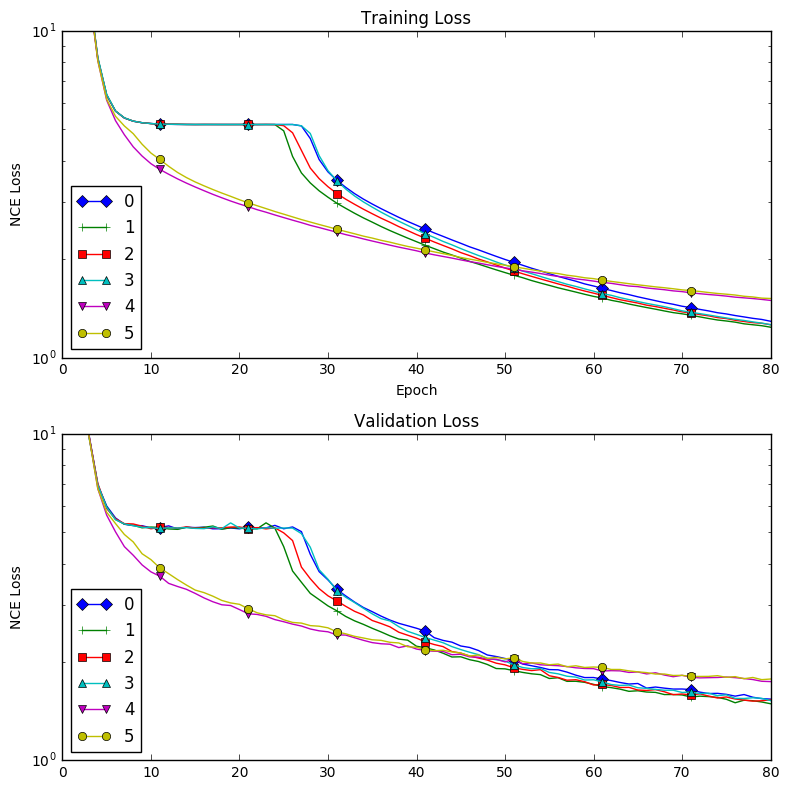

In [5]:
plot_results(results_list)

## Weight Initialization to Output Softmax:
### Standard Normal or Truncated

***Result: Both distributions work equivalently ... use standard normal.***

In [6]:
results_list2 = []
count = 0
for trunc_norm in [True, False]:
    for dummy in range(2):  # run each sim twice
        print('{}) truncated normal? {}, run #{}'.format(count, trunc_norm, dummy))
        count += 1
        graph_params = {'batch_size': 32,
                        'vocab_size': np.max(x)+1,
                        'embed_size': 128,
                        'hid_size': 128,
                        'neg_samples': 64,
                        'learn_rate': 0.003,
                        'embed_noise': 0.1,
                        'hid_noise': 0.1,
                        'trunc_norm': trunc_norm,
                        'optimizer': 'RMSProp'}  
        model = WindowModel(graph_params)
        results = model.train(x_train, y_train, x_val, y_val, epochs=80, verbose=False)
        results_list2.append((graph_params, results))

0) truncated normal? True, run #0
End Training: total batches = 551200. train loss = 1.33, val loss = 1.55
1) truncated normal? True, run #1
End Training: total batches = 551200. train loss = 1.21, val loss = 1.47
2) truncated normal? False, run #0
End Training: total batches = 551200. train loss = 1.24, val loss = 1.49
3) truncated normal? False, run #1
End Training: total batches = 551200. train loss = 1.35, val loss = 1.58


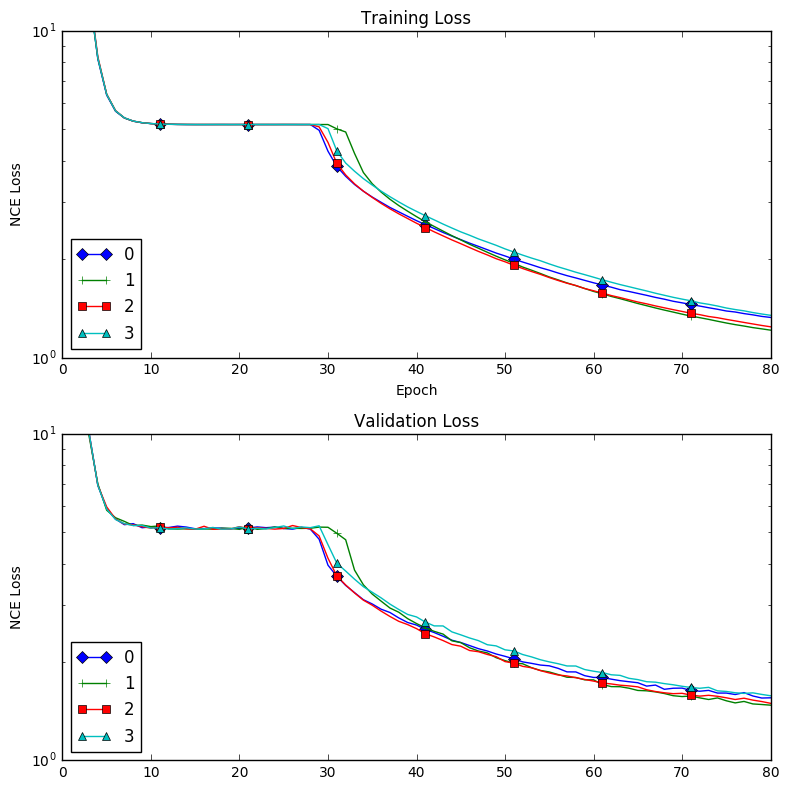

In [7]:
plot_results(results_list2)

## Weight Initialization to Hidden Layer

sigma = {0.1, 1, 10} * 1/sqrt(# of node inputs)

In [8]:
results_list3 = []
count = 0
for hid_noise in [0.1, 1, 10]:
    for dummy in range(2):  # run each sim twice
        print('{}) hidden layer sigma {}, run #{}'.format(count, hid_noise, dummy))
        count += 1
        graph_params = {'batch_size': 32,
                        'vocab_size': np.max(x)+1,
                        'embed_size': 128,
                        'hid_size': 128,
                        'neg_samples': 64,
                        'learn_rate': 0.003,
                        'embed_noise': 0.1,
                        'hid_noise': hid_noise,
                        'optimizer': 'RMSProp'}
        model = WindowModel(graph_params)
        results = model.train(x_train, y_train, x_val, y_val, epochs=50, verbose=False)
        results_list3.append((graph_params, results))

0) hidden layer sigma 0.1, run #0
End Training: total batches = 344500. train loss = 1.60, val loss = 1.78
1) hidden layer sigma 0.1, run #1
End Training: total batches = 344500. train loss = 1.73, val loss = 1.86
2) hidden layer sigma 1, run #0
End Training: total batches = 344500. train loss = 1.70, val loss = 1.82
3) hidden layer sigma 1, run #1
End Training: total batches = 344500. train loss = 1.81, val loss = 1.92
4) hidden layer sigma 10, run #0
End Training: total batches = 344500. train loss = 1.50, val loss = 1.70
5) hidden layer sigma 10, run #1
End Training: total batches = 344500. train loss = 1.47, val loss = 1.65


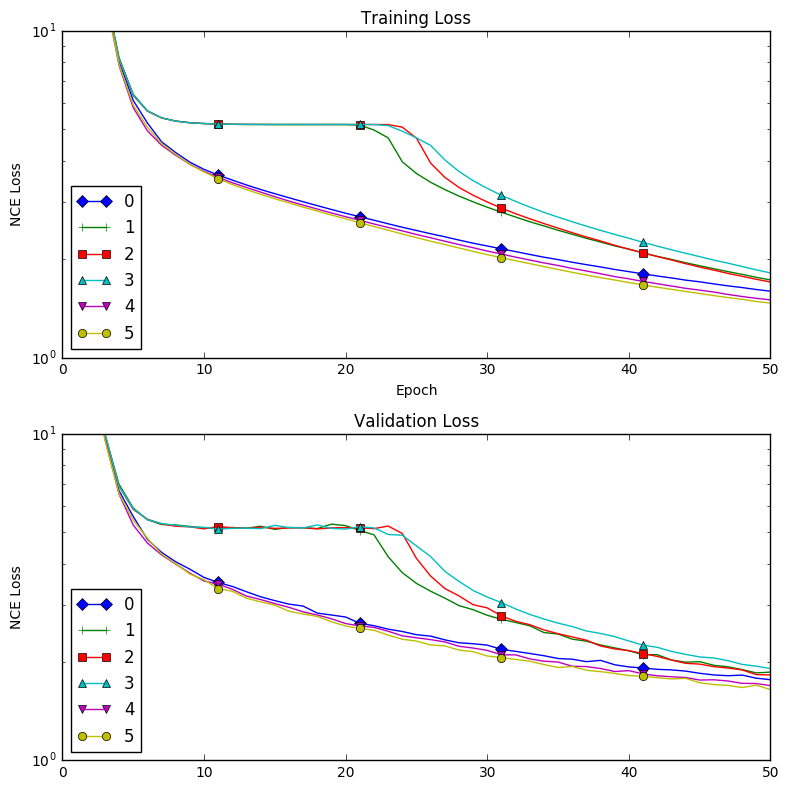

In [9]:
plot_results(results_list3)